# Lab Deep Learning/ Recurrent Neural Networks/ in keras

## Training language model (Many-to-Many) and generating sequences (One-to-Many)

**Author: geoffroy.peeters@telecom-paris.fr**

**Version**: 2020/10/05 (changed to tensorfow.keras)

For any remark or suggestion, please feel free to contact me.


## Objective:

- We will train a network to learn a language model and then use it to generate new sequences.

- Instead of training the language model on text-documents (as it is the case in most examples) we will train it to learn the language of the music of [Johann_Sebastian_Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach).
For this, we will learn how J. S. Bach's "Cello suite" have been composed.
Here is an example of a "Cello suite" [Link](https://www.youtube.com/watch?v=mGQLXRTl3Z0).

- Rather than analyzing the audio signal, we use a symbolic representation of the "Cello suite" through their [MIDI files](https://en.wikipedia.org/wiki/MIDI#MIDI_files).
  - A MIDI file encodes in a file, the set of musical notes, their duration, and intensity which have to be played by each instrument to "render" a musical piece. The "rendering" is usually operated by a MIDI synthesizer (such as VLC, QuickTime).

- We will first train a language model on the whole set of MIDI files of the "Cello suites". 
- We will then sample this language model to create a new MIDI file which will be a brand new "Cello suite" composed by the computer.

### Questions:

In the bottom part of this lab, you will have to answer a set of questions. Answers to those only necessitates a couple of sentences.

## Import packages

In [ ]:
! pip install pretty_midi

import os
import pretty_midi
from scipy.io import wavfile 
import IPython

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation

import matplotlib.pyplot as plt
import numpy as np
import glob

student = True

     |████████████████████████████████| 5.6MB 26.8MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp37-none-any.whl size=5591958 sha256=562cc79aff0d7155066e8ea903594c0c7c64d8ddc8076010b77203b399c98261
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi


# Get the data

In [ ]:
n_x = 79
max_T_x = 1000
sequence_length = 20
T_y_generated = 200

## Collect data to create the language model

We download the 36 MIDI files corresponding to the 36 "Cello suites" composed by J. S. Bach.

In [ ]:
!mkdir _audio
DIR = './_audio/'
import urllib.request
midiFile_l = ['cs1-2all.mid', 'cs5-1pre.mid', 'cs4-1pre.mid', 'cs3-5bou.mid', 'cs1-4sar.mid', 'cs2-5men.mid', 'cs3-3cou.mid', 'cs2-3cou.mid', 'cs1-6gig.mid', 'cs6-4sar.mid', 'cs4-5bou.mid', 'cs4-3cou.mid', 'cs5-3cou.mid', 'cs6-5gav.mid', 'cs6-6gig.mid', 'cs6-2all.mid', 'cs2-1pre.mid', 'cs3-1pre.mid', 'cs3-6gig.mid', 'cs2-6gig.mid', 'cs2-4sar.mid', 'cs3-4sar.mid', 'cs1-5men.mid', 'cs1-3cou.mid', 'cs6-1pre.mid', 'cs2-2all.mid', 'cs3-2all.mid', 'cs1-1pre.mid', 'cs5-2all.mid', 'cs4-2all.mid', 'cs5-5gav.mid', 'cs4-6gig.mid', 'cs5-6gig.mid', 'cs5-4sar.mid', 'cs4-4sar.mid', 'cs6-3cou.mid']
for midiFile in midiFile_l:
  #if os.path.isfile(DIR + midiFile) is None:
  urllib.request.urlretrieve ("http://www.jsbach.net/midi/" + midiFile, DIR + midiFile)
nbExample = len(midiFile_l)

midiFile_l = glob.glob(DIR + 'cs*.mid')
print(midiFile_l)

['./_audio/cs6-1pre.mid', './_audio/cs2-6gig.mid', './_audio/cs1-5men.mid', './_audio/cs6-3cou.mid', './_audio/cs2-3cou.mid', './_audio/cs4-6gig.mid', './_audio/cs5-6gig.mid', './_audio/cs2-4sar.mid', './_audio/cs2-2all.mid', './_audio/cs6-6gig.mid', './_audio/cs6-4sar.mid', './_audio/cs3-6gig.mid', './_audio/cs3-5bou.mid', './_audio/cs5-3cou.mid', './_audio/cs4-3cou.mid', './_audio/cs3-1pre.mid', './_audio/cs2-5men.mid', './_audio/cs5-1pre.mid', './_audio/cs3-2all.mid', './_audio/cs3-4sar.mid', './_audio/cs1-1pre.mid', './_audio/cs2-1pre.mid', './_audio/cs3-3cou.mid', './_audio/cs5-4sar.mid', './_audio/cs6-5gav.mid', './_audio/cs4-2all.mid', './_audio/cs1-4sar.mid', './_audio/cs4-5bou.mid', './_audio/cs5-2all.mid', './_audio/cs4-1pre.mid', './_audio/cs4-4sar.mid', './_audio/cs1-6gig.mid', './_audio/cs6-2all.mid', './_audio/cs5-5gav.mid', './_audio/cs1-3cou.mid', './_audio/cs1-2all.mid']


## Read and convert all MIDI files

In [ ]:
# --- Read a single MIDI file
midi_data = pretty_midi.PrettyMIDI(midiFile_l[0])
# --- Display the note pitch, start, end and duration
for note in midi_data.instruments[0].notes:
    print('pitch: %d, start: %f, end: %f, duration: %f' % (note.pitch, note.start, note.end, note.end-note.start))

pitch: 50, start: 0.000000, end: 0.230769, duration: 0.230769
pitch: 50, start: 0.461538, end: 0.692307, duration: 0.230769
pitch: 50, start: 0.692307, end: 0.923076, duration: 0.230769
pitch: 54, start: 1.153845, end: 1.384614, duration: 0.230769
pitch: 50, start: 1.384614, end: 1.615383, duration: 0.230769
pitch: 57, start: 1.846152, end: 2.076921, duration: 0.230769
pitch: 50, start: 2.076921, end: 2.307690, duration: 0.230769
pitch: 62, start: 2.538459, end: 2.769228, duration: 0.230769
pitch: 50, start: 2.769228, end: 2.999997, duration: 0.230769
pitch: 50, start: 3.230766, end: 3.461535, duration: 0.230769
pitch: 50, start: 3.461535, end: 3.692304, duration: 0.230769
pitch: 54, start: 3.923073, end: 4.153842, duration: 0.230769
pitch: 50, start: 4.153842, end: 4.384611, duration: 0.230769
pitch: 57, start: 4.615380, end: 4.846149, duration: 0.230769
pitch: 50, start: 4.846149, end: 5.076918, duration: 0.230769
pitch: 62, start: 5.307687, end: 5.538456, duration: 0.230769
pitch: 5

We read all MIDI files and convert their content to one-hot-encoding matrix X_ohe of dimensions (T_x, n_x) where n_x is the number of possible musical notes.
The duration of the sequences T_x can vary from one sequence to the other.
 


In [ ]:
# --- We truncate the duration of each example to the first T_x data

X_list = []

for midiFile in midiFile_l:
    # read the MIDI file
    midi_data = pretty_midi.PrettyMIDI(midiFile)
    note_l = [note.pitch for note in midi_data.instruments[0].notes]
    # convert to one-hot-encoding
    T_x = len(note_l)
    if T_x > max_T_x:
      T_x = max_T_x
    X_ohe = np.zeros((T_x, n_x))
    for t in range(T_x): 
      X_ohe[t, note_l[t]-1] = 1
    # add to the list  
    X_list.append(X_ohe)
    
print(len(X_list))
print(X_list[0].shape)
print(X_list[1].shape)
print(X_list[2].shape)

36
(1000, 79)
(690, 79)
(642, 79)


## Display the set of notes over time for a specific track 

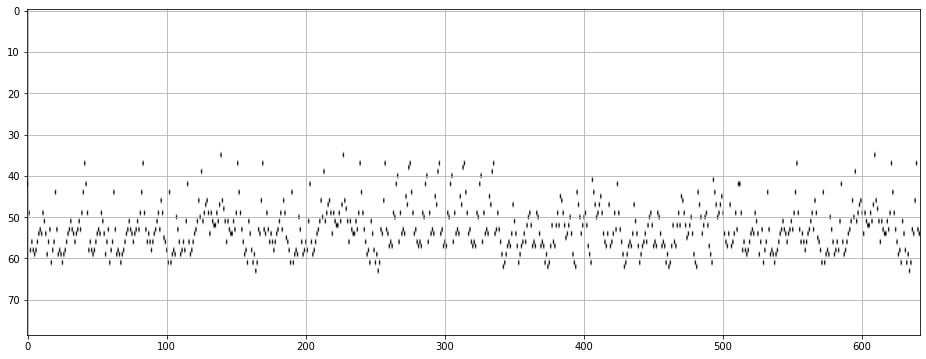

In [ ]:
plt.figure(figsize=(16, 6))
plt.imshow(X_list[2].T, aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

## Data conversion for the training of language model

For each example/sequence and each possible starting note in this example/sequence, we create two sequences
- an input sequence: 
  - which contains a sub-sequence of length ```sequence_length```;  this sub-sequence range from the note $t$ to the note $t+sequence\_length-1$
- an output sequence:
  - which contains the following note to be predicted, the one at position $t+sequence\_length$

The training is therefore performed by giving to the model a set of sequences as input and asking the network to predict each time the note that should come right after this sequence.

<img src="https://perso.telecom-paristech.fr/gpeeters/doc/Lab_DL_RNN_02.png">


In [ ]:
X_train_list = []
y_train_list = []

if student:
    # --- START CODE HERE (01)
    for X in X_list:
      for i in range(X.shape[0]-20):
        X_train_list.append(X[i:i+sequence_length,:])
        y_train_list.append(X[i+sequence_length,:])
    # --- END CODE HERE

X_train = np.asarray(X_train_list)
y_train = np.asarray(y_train_list)

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (23781, 20, 79)
y_train.shape: (23781, 79)


# Training the language model

The language model will be learned by training an RNN with input `X_train` and output `Y_train`:  for each of the examples of sequences, we give to the network a sequence of notes of `sequence_length` duration, and ask the network to predict the following note of each sequence.

The network will have the following structure
- (1a) a layer of `LSTM` with $n_a$=256
- (1b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (2a) a layer of `LSTM` with $n_a$=256
- (2b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (3) a layer of `LSTM` with $n_a$=256
- (4a) a layer of `Dense` with 256 units
- (4b) a layer of DropOut with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- (5) a layer of `Dense` with a `softmax` activation which predict the probability of each of the $n_x$ notes as output

## Returning the hidden states at each time of an LSTM cell

Note that when we stack one LSTM layer on top of a second LSTM layer (deep-RNN), we need to tell the first LSTM to output its hidden states at each time $t$. This is done by the option `return_sequences=True` that has to be given as parameter to the LSTM on top of the other one.
This is the case for (1a) and (2a).

However, since we are only interrested in the last hidden state of the third LSTM (since we are only interrest in its prediction at time $T_x$), we give the option `return_sequences=False` (which is the default behaviour) for the third LSTM.
This is the case for (3).

In [ ]:
# --- Create the model
K.clear_session()

if student:
    # --- START CODE HERE (02)
    model = Sequential()
    model.add(LSTM(256,input_shape=(20,79,), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(256,return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(256))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(79,activation='softmax'))
    # --- END CODE HERE

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 256)           344064    
_________________________________________________________________
dropout (Dropout)            (None, 20, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 256)           525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

In [ ]:
# --- Compile and fit the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
372/372 [==============================] - 136s 352ms/step - loss: 2.9231 - accuracy: 0.1159
Epoch 2/10
372/372 [==============================] - 129s 348ms/step - loss: 2.6087 - accuracy: 0.1633
Epoch 3/10
372/372 [==============================] - 130s 348ms/step - loss: 2.5280 - accuracy: 0.1873
Epoch 4/10
372/372 [==============================] - 128s 345ms/step - loss: 2.4571 - accuracy: 0.2234
Epoch 5/10
372/372 [==============================] - 128s 345ms/step - loss: 2.3614 - accuracy: 0.2704
Epoch 6/10
372/372 [==============================] - 129s 347ms/step - loss: 2.2462 - accuracy: 0.3129
Epoch 7/10
372/372 [==============================] - 129s 346ms/step - loss: 2.1208 - accuracy: 0.3559
Epoch 8/10
372/372 [==============================] - 127s 341ms/step - loss: 1.9848 - accuracy: 0.3902
Epoch 9/10
372/372 [==============================] - 128s 343ms/step - loss: 1.8292 - accuracy: 0.4395
Epoch 10/10
372/372 [==============================] - 126s 340m

# Generating a new sequence from sampling the language model

To generate a new sequence from the language model, we simply give it as input a random sequence of duration ```sequence_length```and ask the trained network to predict the output (using ```model.predict```). 

The output of the network is a vector of probability of dimension $n_x$ which represents the probability of each note to be the next note of the melody given as input.

From this vector, we select the note which has the maximum probability.

We then concatenate this new note (its one-hot-encoding representation) at the end of the input sequence.
We finally remove the first element of the input sequence to keep its duration constant (```sequence_length```).

Instead of providing a random sequence as input, we rather randomly select one sequence out of the 23.781 sequences used for training.

- The ```pattern``` variable is the ```list``` of init notes to which we progressively append the new generated notes by the model.
- The ```prediction``` variable is a ```list``` which stores the softmax probability vector (a numpy array) corresponding to each generation time.


In [ ]:
# --- Select a random starting pattern
start = np.random.randint(0, len(X_train_list)-1)
pattern = X_train_list[start]
print(start)
print(pattern.shape)
print(np.expand_dims(pattern, 0).shape)

19925
(20, 79)
(1, 20, 79)


In [ ]:
# --- note_l: is the list of notes (integer number) over time
note_l = []
# --- prediction_l: is the list of output-vectors (float numbers \in [0,1]) of the network over time
prediction_l = []
# --- Generate T_y_generated notes
for note_index in range(T_y_generated):
    if student:
        # --- START CODE HERE (03)
        prediction = model.predict(np.expand_dims(pattern, 0))
        note = np.argmax(prediction)
        pattern[0:sequence_length-1,:] = pattern[1:sequence_length,:]
        pattern[sequence_length-1,:] = np.zeros(79)
        pattern[sequence_length-1,note] = 1

        note_l.append(note)
        prediction_l.append(prediction)
        # --- END CODE HERE    

### Display the generated sequence

[46, 46, 49, 49, 46, 46, 49, 49, 46, 49, 46, 49, 46, 44, 46, 52, 49, 51, 52, 49, 51, 52, 54, 56, 58, 59, 61, 63, 59, 58, 56, 54, 52, 51, 52, 49, 51, 52, 49, 46, 47, 49, 46, 49, 49, 46, 49, 49, 46, 49, 49, 46, 49, 49, 58, 49, 51, 52, 49, 51, 52, 49, 51, 52, 49, 46, 49, 58, 59, 58, 56, 58, 59, 56, 52, 51, 52, 49, 51, 52, 49, 51, 52, 49, 46, 49, 58, 61, 58, 59, 58, 56, 58, 59, 56, 52, 51, 52, 49, 51, 52, 49, 51, 52, 49, 46, 49, 58, 61, 58, 59, 58, 56, 58, 59, 56, 52, 51, 52, 49, 51, 52, 49, 51, 52, 49, 46, 49, 58, 61, 58, 59, 58, 56, 58, 59, 56, 52, 51, 52, 49, 51, 52, 49, 51, 52, 49, 46, 49, 58, 61, 58, 59, 58, 56, 58, 59, 56, 52, 51, 52, 49, 51, 52, 49, 51, 52, 49, 46, 49, 58, 61, 58, 59, 58, 56, 58, 59, 56, 52, 51, 52, 49, 51, 52, 49, 51, 52, 49, 46, 49, 58, 61, 58, 59, 58, 56, 58, 59, 56]


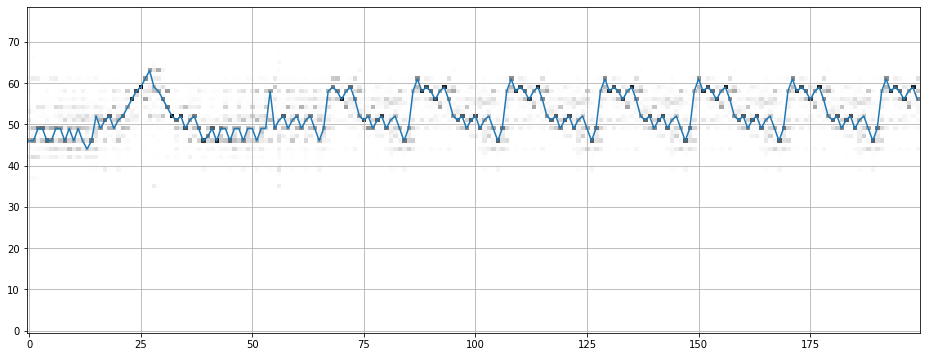

In [ ]:
print(note_l)

plt.figure(figsize=(16, 6))
plt.imshow(np.asarray(prediction_l)[:,0,:].T, aspect='auto', origin='lower')
plt.plot(note_l)
plt.set_cmap('gray_r')
plt.grid(True)


### Create a MIDI file and an audio file which correspond to the generated sequence

Once the new sequence has been generated (```note_l```) we transform it to a new MIDI file and perform (a very cheap) rendering of it in an audio file.

In [ ]:
new_midi_data = pretty_midi.PrettyMIDI()
cello_program = pretty_midi.instrument_name_to_program('Cello')
cello = pretty_midi.Instrument(program=cello_program)
time = 0
step = 0.3
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+step)
    cello.notes.append(myNote)
    time += step
new_midi_data.instruments.append(cello)
new_midi_data.write('output.mid')

In [ ]:
%matplotlib inline

audio_data = new_midi_data.synthesize(fs=44100)
IPython.display.Audio(audio_data, rate=44100)

# Evaluation

To evaluate the work, you should rate the code for 
- 1) Data conversion for the training of language model (01)
- 2) Training the language model (02)
- 3) Generating a new sequence from sampling the language model (03)

You will also rate the answer to the four questions below.

## Question 1)

Que se passe-t'il si on remplace la cellule LSTM par une cellule RNNsimple ?

**Réponse (en-dessous)** (1 points)

Gradient vanishing, because during the backpropogation, we multiply the matrix many times and because of the effect of softmax

## Question 2) 

Que se passe-t'il si l'on raccourci la longueur des séquences utilisées pour l'entrainement ? Comment palier à cet effet ?

**Réponse (en-dessous)** (1 points)

Then the model only has a short memory.

## Question 3) 
Comment pourrait-on rendre le système ```polyphonique``` (plusieurs notes jouées simultanément par le même instrument) ? pour l'entrainement ? pour la génération ?

**Réponse (en-dessous)** (2 points)

multi-label classification task

Use sigmoid for each note, and then use binary cross entropy for each note in training.

For generation, we just use np.argmax(score) for each note or we can use a thresh

## Question 4) 

Nous avons utilisé une procédure simplifiée pour entrainer le modèle de language musical, en transformant l'apprentissage en un problème Many-To-one. Expliquez ? Comment entraine-t'on habituellement un modèle de language avec un RNN ? Quel en serait l'avantage ?

**Réponse (en-dessous)** (2 points)

For a normal RNN model, it's simpler and faster, because we don't have to train so many sequences.